# ASI Final Assignment

https://github.com/mspronesti/advanced-statistical-inference

## Load the Dataset



In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/

Mounted at /content/drive
/content/drive/MyDrive


In [2]:
# load from kaggle using kaggle.json config file from drive
# assumption: kaggle.json is located under the main root in your drive

###################################
# If you run this notebook multiple
# times, comment the following 
# lines after the very first one, 
# not to delete and re-download 
# the dataset again 
###################################

# import os
# os.environ["KAGGLE_CONFIG_DIR"]='/content/drive/My Drive'
# !kaggle competitions download -c santander-customer-transaction-prediction
# !unzip -p santander-customer-transaction-prediction.zip train.csv > train.csv 
# !rm santander-customer-transaction-prediction.zip

In [3]:
!nvidia-smi

Mon May 30 07:33:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 0. Data Exploration

#### **A) Download and import the Santander dataset. The labels of the test data are not publicly available, so create your own test set by randomly choosing half of the instances in the original training set**

In [4]:
import pandas as pd
# import modin.pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

data = pd.read_csv('train.csv')

# drop the ID code and split data and labels
df_data = data.drop(columns=['target', 'ID_code'])
df_target = data['target']


# split the dataset
X_train, X_test, y_train, y_test = \
  train_test_split(df_data, df_target, test_size=0.5, shuffle=True, random_state=42)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

#### **B) Comment on the distribution of class labels and the dimensionality of the input and how these may affect the analysis.**

The Santander Customer Transaction dataset is characterized binary labels, so that we can evaluate the distribution of the class labels simply summing them and dividing by the number of samples 

1s percentage = 0.099600
0s percentage = 0.900400


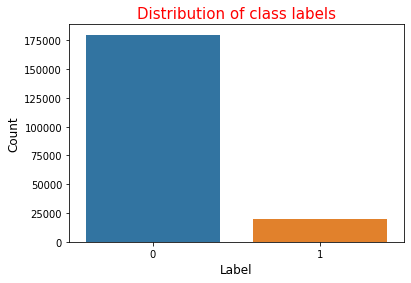

In [5]:
import matplotlib.pyplot as plt
import seaborn as sb

ones_percentage = np.sum(y_train) / len(y_train)
print('1s percentage = %f' % ones_percentage)
print('0s percentage = %f' % (1. - ones_percentage))


# plot the label distribution
ax = sb.countplot(x='target', data=data)
ax.set_xlabel("Label", size=12)
ax.set_ylabel("Count", size=12)
ax.set_title("Distribution of class labels",  color='r', size=15)
plt.show()

Hence the dataset is pretty unbalanced, with one class being present almost 10 times more than the other.

Opting to use the dataset as it is forces us to discard the accuracy as a valuable metrics as a dummy model always outputting 0 is going to have 90% accuracy.

We might anyway consider to balance the dataset, using an oversampling technique (e.g. SMOTE) but in the end I regarded the obtained results good enough not to do it.

## 1. Bayesian Linear Regression

#### **A) Implement   Bayesian   linear   regression**

In [6]:
import numpy as np
from numpy.linalg import inv as inverse

###################################################
## Bayesian Linear Regression utils              ##
###################################################

def build_features(x, K):
    # assert K is legit 
    assert isinstance(K, (int, np.int32, np.int64)) and K > 0
    # first column of the matrix (the bias)
    ones = np.ones(x.shape[0])
    # following columns containing the Kth powers of the feature
    power_stack = np.column_stack(tuple(x ** k for k in range(1, K+1)))
    return np.column_stack((ones, power_stack))

def sklearn_build_features(x, K):
  from sklearn.preprocessing import PolynomialFeatures
  poly = PolynomialFeatures(K)
  return poly.fit_transform(x)

def compute_posterior(X, y, sw2, sn2):
    """
    Args:
      X: the design matrix compute previously
         (or the features, in ML terminology)
      y: labels
      sw2: sigma_w ^ 2
      sn2: sigma_n ^ 2
    """
    # just the definitions 
    _, cov_size = X.shape
    # S is a diagonal matrix defined as (see above)
    # S = sw2 * np.eye(cov_size)
    # thus it's inverse is a diag matrix having entries
    # 1 / entry
    S_inv = 1/sw2 * np.eye(cov_size)
    
    Sigma_inv = 1/sn2 * X.T @ X + S_inv
    Sigma = inverse(Sigma_inv)
    # now the posterior covariance is just the inverse of \Sigma^-1, i.e. Sigma
    w_posterior_cov = Sigma
    w_posterior_mean = (1/sn2) * Sigma @ X.T @ y
    
    return (
        w_posterior_mean, 
        w_posterior_cov
    )

def compute_predictive(Xt, w_mean, w_cov, sn2):
    def _compute_predictive_single_point(xt_i, w_mean, w_cov, sn2):
        # reasoning: see the identity to prove in the above question
        yt_i_mean = xt_i.T @ w_mean
        yt_i_var = sn2 + xt_i @ w_cov @ xt_i 
        return yt_i_mean, yt_i_var

    yt_mean, yt_var = np.zeros(len(Xt)), np.zeros(len(Xt))
    for i, xt_i in enumerate(Xt):  # Loop on all the points
        yt_mean[i], yt_var[i] = _compute_predictive_single_point(
            xt_i, w_mean, w_cov, sn2
        )
        
    return yt_mean, yt_var


###################################################
## Bayesian Linear Regression class              ##
###################################################

class BayesianLinearRegression:
  """Bayesian Linear Regression class"""
  def __init__(self, sw2, sn2):
    self.sw2_ = sw2
    self.sn2_ = sn2
    self.w_posterior_cov_ = None
    self.w_posterior_mean_ = None

  def fit(self, X, y, with_bias=False):
    """
    Fits the BLR and retrieves
    the fitted object

    Args:
      X: 
        training data
        expected with bias term
      y: 
        training samples

    Return:
      the fitted object
    """
    self.w_posterior_mean_, self.w_posterior_cov_ = \
     compute_posterior(X, y, self.sw2_, self.sn2_)
    return self

  def predict(self, X):
    """
    Predicts the labels for the test
    data X using the computed posterior
    
    Args:
      X: test data, expected with bias term
    
    Returns:
      predicted labels
    """
    return compute_predictive(X, self.w_posterior_mean_, 
                              self.w_posterior_cov_, self.sn2_)

#### **B) Describe any pre-processing that you suggest for this data**

To discuss an appropriate pre-processing, let's plot the training data first

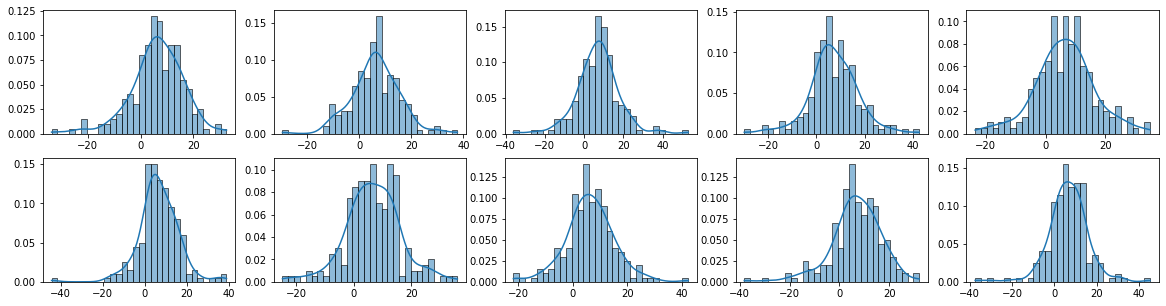

In [7]:
figs, axs = plt.subplots(2, 5, figsize=(20, 5))
axs = axs.flatten()

for i, ax in enumerate(axs):
    sb.histplot(X_train[i], bins=30, kde=True, stat='probability', ax=ax)
    ax.set(ylabel="")
    title = f"w_{i}"

plt.show()

From the above plots, we can notice how the features follow a gaussian-like distribution. Hence, we should first standardize the data ($\mu = 0, \ \sigma^2 = 1$)

In [8]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

We could also consider reducing the number of features using a dimensionality reduction technique. To this purpose, let's briefly study the correlation between the 200 features

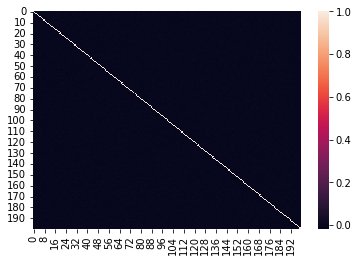

In [9]:
corr_mat = pd.DataFrame(X_train).corr()
plt.subplots()
sb.heatmap(corr_mat)
plt.show()

The heatmap reveals that all the features are important, hence I will proceed keeping all of them.

#### **C) Treat class labels as continuous and apply regression to the training data. Also, calculate and report the posterior variance of the weights**

([<matplotlib.axis.XTick at 0x7efc7b010510>,
 [Text(0, 0, '100'),
  Text(0, 0, '1000'),
  Text(0, 0, '10000'),
  Text(0, 0, '100000')])

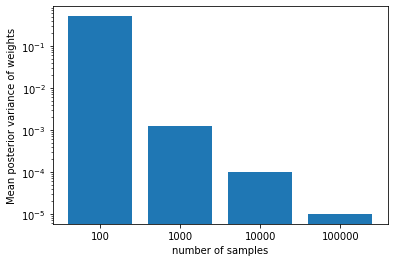

In [10]:
sn2 = 1
sw2 = 1
K = 1
   
X = build_features(X_train, K)

# samples to iterate over
samples = [100, 1000, 10000, 100000]
# list to store the means of the posterior covariances
w_posterior_cov_means = []

for i in samples:
  _, w_posterior_cov = compute_posterior(X[0:i], y_train[0:i], sn2, sw2)
  mean_var = np.mean(np.diag(w_posterior_cov))
  w_posterior_cov_means.append(mean_var)

plt.bar(x=range(len(samples)), height=w_posterior_cov_means)
plt.yscale('log')
plt.xlabel('number of samples')
plt.ylabel('Mean posterior variance of weights')
plt.xticks(range(len(samples)), samples)

In [11]:
blr = BayesianLinearRegression(sw2, sn2)
# evaluate the posterior
blr.fit(X, y_train)

# bayesian prediction on train

y_mean_tr, y_var_tr = blr.predict(X)

# bayesian prediction on test
X_test_ = build_features(X_test, K)
y_mean, y_var = blr.predict(X_test_)

#### **D) Suggest a way to discretize predictions and display the confusion matrix on the test data and report accuracy**

To discretize the prediction we need to find a cutoff point that maximize the score. As already declared, using the accuracy for unbalanced data is not recommended, as we will end up with a very low sensitivity.
To have a better understanding of the results we can exploit the ROC curve and the AUC score so that our final discretization is gonna depend on the optimal threshold

$$ y_{pred\_i} = \begin{cases}
0\text{ if } \hat{y} < opt\_threshold \\ 
1\text{ if }  \hat{y} \ge opt\_threshold
\end{cases}$$

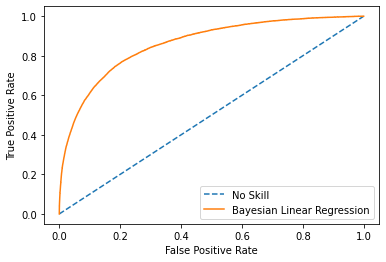


Optimal threshold 0.18
Accuracy score: 0.791270
F1 score: 0.428153
AUC: 0.782173
Sensitivity: 0.793583
Specificity: 0.770763



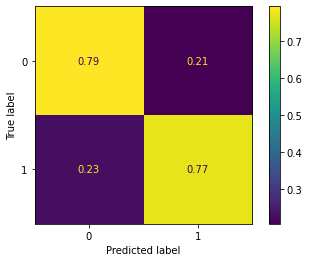

In [12]:
from sklearn.metrics import (
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    roc_curve, 
    roc_auc_score,
    accuracy_score,
    f1_score
)

def display_roc_cm_scores(y_test, y_pred, label=""):
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)

  plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
  plt.plot(fpr, tpr,  label=label)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()

  optimal_idx = np.argmax(tpr - fpr)
  optimal_threshold = thresholds[optimal_idx]

  print("\nOptimal threshold %.2f" % optimal_threshold )

  y_pred = y_pred >= optimal_threshold

  print("Accuracy score: %f" % accuracy_score(y_test, y_pred))
  print("F1 score: %f" % f1_score(y_test, y_pred))
  print("AUC: %f" % roc_auc_score(y_test, y_pred))

  # plot the confusion matrix
  cm = confusion_matrix(y_test, y_pred)

  sensitivity = cm[0,0] / (cm[0,0] + cm[0,1])
  specificity = cm[1,1] / (cm[1,0] + cm[1,1])

  print("Sensitivity: %f" % sensitivity)
  print("Specificity: %f\n" % specificity)

  # normalized confusion matrix
  disp = ConfusionMatrixDisplay(confusion_matrix=cm/cm.sum(axis=1)[:, np.newaxis])
  disp.plot()
  

display_roc_cm_scores(y_test, y_mean, "Bayesian Linear Regression")

## 2. Logistic Regression

#### **A) The goal is to implement a Bayesian logistic regression classifier; assume a Gaussian prior on the parameters. As a first step, implement a Markov chain Monte Carlo inference algorithm to infer parameters**

In [13]:
from tqdm import tqdm

###################################################
##             MCMC utils                        ##
###################################################

# bruttissima cosa, da levare
# serve solo a far andare rw_mh_step 
# che non li prende come parametro 
X = X_train
y = y_train


def logistic(z):
    return 1 / (1 + np.exp(-z))

def bernoulli_density(y, p, jitter=1e-10):
    return y.T * np.log(p + jitter) + (1 - y).T * np.log(1 - p + jitter)

def gaussian_density(x, mean=0, var=1):
    return - .5 * np.log(2 * np.pi * var) - .5 * (x - mean)**2 / var 

def logposterior(w, X, y):
    # compute model output
    # and feed it to the logistic regression
    p = logistic(X @ w)
    # apply bernoulli to get
    # the log likelihood point by point
    log_lik = bernoulli_density(y, p)
    prior = gaussian_density(w)
    # add the summations because the above computations
    # are point by point 
    return np.sum(log_lik) + np.sum(prior)

def rw_mh_step(w_prev, step_size):
    # step size used for the covariance 
    # see slide 32
    # x ~ N(mu, sigma^2) <=> x ~ sigma * eps + mu 
    # being eps ~ N(0,1)
    # in other words we sample from a normal distribution with 0 mean
    # and variance 1 and then we multiply it by the std-dev (i.e. step size) 
    # and we add mu
    ws_tilde = np.random.multivariate_normal(
      mean = w_prev, 
      cov = step_size * np.eye(len(w_prev))
    )
    # in this scenario , mu = w_prev and the standard deviation is
    # step_size
    #ws_tilde = ws_tilde * step_size + w_prev
    # compute the acceptance ratio
    # notice that the second term is = 1 because of symmetry in Gaussians

    # the difference is because we're dealing with logs and then we reconvert to exps
    # equivalently we could do exp of both and then divide
    ratio = logposterior(ws_tilde, X, y) - logposterior(w_prev, X, y)
    ratio = np.exp(ratio)
    # acceptance
    return ws_tilde if ratio >= 1 or ratio >= np.random.uniform(0, 1) else w_prev

def run_sampling(w, n_samples, step_size=1, burn_in=0):
    w = np.atleast_1d(w)
    samples = np.empty((n_samples, *w.shape))
    for i in tqdm(range(n_samples)):
        w = rw_mh_step(w, step_size)
        samples[i] = w

    return samples[burn_in:, :]

In [14]:

_, n_feats = X.shape

# MH params
w_init = np.random.rand(n_feats)
n_samples = 10000
step_size = 1e-4

# metropolis sampler (temporary keep all the samples - no burn_in specified -, 
# then discard according to the trace plots)
samples = run_sampling(w_init, n_samples, step_size)

100%|██████████| 10000/10000 [09:42<00:00, 17.16it/s]


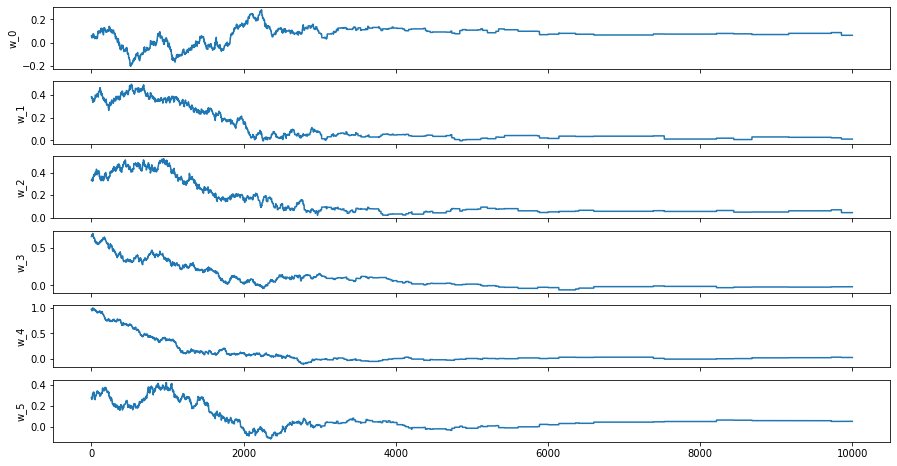

In [15]:
fig, axes_tuple = plt.subplots(6, 1, figsize=[15, 8], sharex=True)

for i, ax in enumerate(axes_tuple):
  ax.plot(list(range(0, samples.shape[0])), samples[:, i])
  ax.set_ylabel(f'w_{i}')

plt.show()

In [16]:
# Introduce a burn-in 
samples_ = samples[4000:, :]

# now predict
def predict(Xt, samples):
    # see slide 81 for the formula
    # too much RAM required for this
    #return np.mean(logistic(samples @ Xt.T), axis=0)
    n_samples = samples.shape[0]

    sum = 0
    for i in tqdm(range(n_samples)):
      sum += logistic(Xt @ samples[i])

    return 1/n_samples * sum

y_mh_pred = predict(X_test, samples_)

100%|██████████| 6000/6000 [01:34<00:00, 63.44it/s]


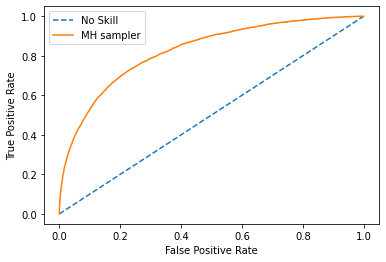


Optimal threshold 0.58
Accuracy score: 0.762970
F1 score: 0.384929
AUC: 0.749056
Sensitivity: 0.766509
Specificity: 0.731604



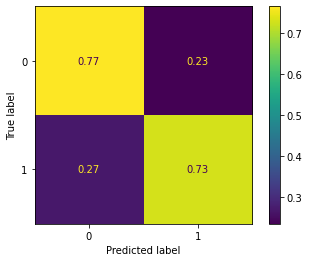

In [17]:
display_roc_cm_scores(y_test, y_mh_pred, "MH sampler")

#### **B) Implement  the  variational  approximation  we  studied  in  the  course  to  obtain  an approximation  to  the  posterior  over  model  parameters**

In [18]:
import jax
import jax.numpy as jnp
from typing import NamedTuple
from functools import partial

#####################################
##  Variational Inference utils    ##
#####################################

class GaussianDiagonal(NamedTuple):
    mean: jnp.array
    log_var: jnp.array

def jnp_bernoulli_density(y, p, jitter=1e-10):
    # bernoully log density rewritten using jax numpy
    return y * jnp.log(p + jitter ) + (1 - y) * jnp.log(1 - p + jitter)

def sample_gaussian_diagonal(rng, params):
    mean, log_var = params
    # extract variance taking the exp 
    # from log variance
    var = jnp.exp(log_var)
    sigma = jnp.sqrt(var)

    eps = jax.random.normal(
        key=rng, 
        shape=mean.shape
    ) 
    return mean + sigma * eps 

def kl_diag_diag(q_params, p_params):
    assert isinstance(q_params, GaussianDiagonal)
    assert isinstance(p_params, GaussianDiagonal)
    mean_q, log_var_q = q_params
    mean_p, log_var_p = p_params

    var_p = jnp.exp(log_var_p)
    var_q = jnp.exp(log_var_q)
    kl = .5 * jnp.sum(
        log_var_p - log_var_q + (var_q + jnp.square(mean_q - mean_p)) / var_p - 1
      )
    return kl

def model(w, X):
    # nested to avoid overwriting
    # the other "logistic", which
    # uses numpy 
    def _logistic(z):
      return 1 / (1 + jnp.exp(-z))
    
    return _logistic(X @ w)

###
# elbo function
###

def create_elbo_fn(sample_fn, likelihood_fn, kl_divergence_fn):
    """Create a function to compute the ELBO, given the function to sample
    from the posterior, the likelihood function and the KL divergence
    """

    @partial(jax.vmap, in_axes=[0, None, None, None])
    def likelihood_sample_fn(rng, q_params, X, y):
        """Compute the likelihood with one Monte Carlo sample of the posterior
        The function is decorated to vectorize multiple MC samples automatically
        """
        # Get one sample of w using the sample_fn and the parameters of q
        # So afterwards  we expect the sample_gaussian_diagonal as sample_fn 
        w = sample_fn(rng, q_params) 
        # Predict the output using the sample before
        yp = model(w, X)
        # Compute the likelihood and return it
        return likelihood_fn(y, yp) 

    def elbo_fn(q_params, p_params, rng, X, y, Nmc=1):
        """Computes the ELBO with multiple samples"""
        # Split the random seed in Nmc times
        rng = jax.random.split(rng, Nmc)

        # Compute the values of the likelihood
        likelihood_vals = likelihood_sample_fn(rng, q_params, X, y) 
        # Compute the expectation (i.e. take the mean)
        expected_likelihood = jnp.mean(jnp.sum(likelihood_vals, axis=1)) 
        # Compute the KL divergence
        kl = kl_divergence_fn(q_params, p_params) 
        # Compute the ELBO
        elbo = expected_likelihood - kl
        # Return the ELBO and its two term (used later for logging)
        return elbo, (expected_likelihood, kl)

    return elbo_fn

elbo_fn = create_elbo_fn(
    sample_fn=sample_gaussian_diagonal, 
    kl_divergence_fn=kl_diag_diag,      
    likelihood_fn=jnp_bernoulli_density     
)

In [19]:
p_params = GaussianDiagonal(jnp.zeros(n_feats), jnp.zeros(n_feats)) 
q_params = GaussianDiagonal(jnp.zeros(n_feats), jnp.zeros(n_feats))
rng = jax.random.PRNGKey(0)

elbo, (likelihood, kl) = elbo_fn(q_params, p_params, rng, X, y)
print("ELBO =", elbo)
print("Likelihood =", likelihood)
print("KL =", kl)

ELBO = -560005.1
Likelihood = -560005.1
KL = 0.0


In [20]:
# Optimization via GD, see lab4 part 5 for details on the implementation 
def sg_update(params, gradients, learning_rate=1e-3):
    updated_params = jax.tree_map(lambda p, g: p + learning_rate * g, params, gradients)
    return updated_params

grad_elbo_fn = jax.grad(elbo_fn, has_aux=True)
grad_elbo_fn = jax.jit(grad_elbo_fn, static_argnames=("Nmc"))

In [21]:
elbo_summary = []
lik_summary = []
kl_summary = []
import math
lr = 1e-5

for i in tqdm(range(10000), desc="Training ELBO"):
    rng, rng2 = jax.random.split(rng)
    
    q_params_grad, (likelihood, kl) = grad_elbo_fn(q_params, p_params, rng, X_train, y_train, Nmc=1000)
    q_params = sg_update(q_params, q_params_grad, lr)

    lik_summary.append(likelihood)
    kl_summary.append(kl)
    elbo_summary.append(likelihood - kl)

Training ELBO: 100%|██████████| 10000/10000 [11:29<00:00, 14.50it/s]


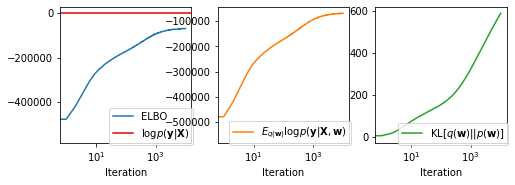

In [22]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=[8, 2.5])

ax0.plot(elbo_summary, label="ELBO")
ax1.plot(
    lik_summary,
    color="tab:orange",
    label=r"$E_{q(\mathbf{w})} \log p(\mathbf{y}|\mathbf{X},\mathbf{w})$",
)
ax2.plot(
    kl_summary,
    color="tab:green",
    label=r"$\mathrm{KL}[{q(\mathbf{w})}||{p(\mathbf{w})}]$",
)

ax0.semilogx()
ax1.semilogx()
ax2.semilogx()

ax0.axhline(-0.4, color="xkcd:red", label=r"$\log p(\mathbf{y}|\mathbf{X})$")
ax0.legend(bbox_to_anchor=(1.05, -0.05), loc="lower right")
ax1.legend(bbox_to_anchor=(1.05, -0.05), loc="lower right")
ax2.legend(bbox_to_anchor=(1.05, -0.05), loc="lower right")

ax0.set_xlabel("Iteration")
ax1.set_xlabel("Iteration")
ax2.set_xlabel("Iteration")

plt.show()

**C) Based  on  samples  from  the  posterior  over  model  parameters,  write  a  function that computes the predictive distribution, and write the necessary functions to evaluate classification metrics such as the log-likelihood on test data and error rate**


In [23]:
def predict_y(sample_fn, q_params, Xt, rng, Nmc=10):
    """Compute the outputs of the model by sampling the posterior,
    then take the expectation
    """

    def predict_y_single(rng):
        w = sample_fn(rng, q_params)
        yp = model(w, Xt)
        return yp

    rng = jax.random.split(rng, Nmc)
    Xt = jnp.atleast_1d(Xt)
    yp = jax.vmap(predict_y_single)(rng)
    # Take the mean
    yp = jnp.mean(yp, axis=0) 
    return yp

y_vi_pred = predict_y(sample_gaussian_diagonal, q_params, X_test, rng, Nmc=1000)
print(y_vi_pred)

[0.22269455 0.35306793 0.35117713 ... 0.3983956  0.65481454 0.8160562 ]


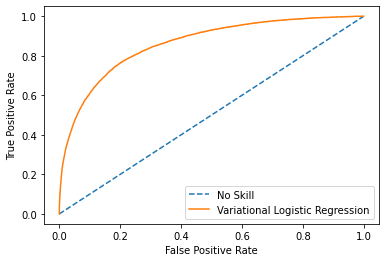


Optimal threshold 0.58
Accuracy score: 0.791520
F1 score: 0.428195
AUC: 0.781963
Sensitivity: 0.793951
Specificity: 0.769974



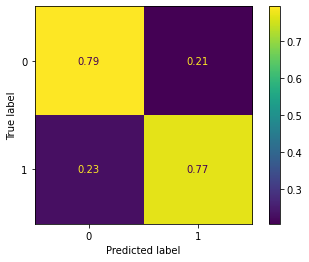

In [26]:
display_roc_cm_scores(y_test, y_vi_pred, "Variational Logistic Regression")

#### **D) Comment  on  the  tuning  of  the  Metropolis-Hastings  algorithm,  and  how  to guarantee  that  samples  are  representative  of  samples  of  the  posterior  over  model parameters**


The tuning of the Metropolis-Hastings algorithm required finding the best values for the following two hyper-parameters:
 * step size
 * number of samples.

As regards the former, I obtained the best performance using $10^{-4}$.

As for the latter, I initially performed a random walk on $10^{4}$ samples and, displaying the trace plots, I applied a burnin of 4000 samples corresponding roughly to the point in the traces where they become stationary.

**E) Comment  on  the  tuning  of  the  variational  inference  algorithm,  and  discuss  the behavior of the optimization with respect to the choice of the optimizer/step-size.**

The variational inference algorithm tries to minimize the ELBO, which is composed by the expected log-likelihood and the KL between the prior distribution and the distribution approximation

\begin{align}
\mathcal{L}(\theta) = \underbrace{\mathbb{E}_{q_{\theta}}\log p(\boldsymbol{y}|\boldsymbol{X}, \boldsymbol{w})}_\text{Expected loglikelihood} -\mathrm{KL}[{q_{\theta}(\boldsymbol{w})}||{p(\boldsymbol{w})}]
\end{align}

However, the analytic evaluation is generally untractable so that we typically resort to sampling techniques using the reparametrization trick, i.e. drawing $N_{MC}$ samples from $q_{\theta}$:


\begin{align}
    \mathbb{E}_{q_{\theta}}\log p(\boldsymbol{y}|\boldsymbol{X}, \boldsymbol{w}) \approx \dfrac{1}{N_\mathrm{MC}} \sum_{\tilde{\boldsymbol{w}}_i\sim q_\theta} \log p(\boldsymbol{y}|\boldsymbol{X}, \tilde{\boldsymbol{w}}_i)
\end{align}

The hyperparameters to tune are therefore:

* `Nmc`: the number of MonteCarlo samples
* `n_iter`: the number of iterations of the ELBO algorithm
* `lr`: the learning rate used for the iterative optimization
 
As for the learning rate, to avoid big "bouncings" during the GD optimization process, we use small values. This is especially for the first iterations, where the KL distance between the approximation and the likelihood is high.

Employing a grid search, I tried the following values:
* `lr` = [1e-2, 1e-3, 1e-4, 1e-5]
* `Nmc` = [10, 100, 1000, 10000]
* `n_iter` = [1000, 10000]

Achieving the best performances with lr = 1e-5, Nmc = 1000 and n_iterations = 10 000.

A further analysis might be conduced using a different optimizer, e.g. Adam.

**F) Report the error metrics implemented in point 2.C. above and the confusion matrix on   the   test   data.   Discuss   logistic   regression   performance   with   respect   to   the performance of  Bayesian linear regression.**

The error metrics and the confusion matrics both for the logistic regression and the Bayesian linear regression are reported in the respective sections and synthesized in the following table:

Accuracy score: 0.775150
F1 score: 0.391689
AUC: 0.748045
Sensitivity: 0.782044

Specificity: 0.714046

| Score | Bayesian Linear Regression | Metropolis-Hastings | Variational Inference |
| :- |  :-: |  :-: | :-: |
| Accuracy | 0.791 | 0.775 | 0.791 |
| Sensitivity | 0.794 | 0.783| 0.794 |
| Specificity | 0.770 | 0.714 | 0.770 |
| F1 score | 0.428 | 0.391 | 0.428 |
| AUC | 0.782 | 0.714 | 0.782 |

Looking at these results we can notice that, despite a lower error rate for linear regression, the number of false positives is the highest of the analyzed cases Therefore as suggested in question B, the imbalanced dataset and the number of features (especially if considered uncorrelated) has a big impact when evaluating the model.

**G) Compare  the  uncertainties  on  predictions  obtained  by  the  Metropolis-Hastings algorithm  and  variational  inference.  First,  compare  the  log-likelihood  on  test  data  as  a 
global metric to assess which inference method yields better uncertainty quantification. Second,  pick  a  few  test  points  for  which  the  mean  of  the  predictive  distribution  is**  


* (a) around  0.5 
* (b)  giving  a  correct  prediction 
* (c)  giving  a  wrong  prediction 

**and  visualize/discuss  what  the  predictive  distribution  looks  like.  Discuss  the  difference  between  the Metropolis-Hastings algorithm and variational inference.**

In [27]:
def logistic_loglik(y, y_tilde):
    ll = y * np.log(y_tilde + 1e-10) + (1 - y)* np.log(1 - y_tilde + 1e-10)
    return np.mean(ll)

In [28]:
print("VI Logistic Regression log-likelihood: %f" % logistic_loglik(y_test, y_vi_pred))
print("MH Logistic Regression log-likelihood: %f" % logistic_loglik(y_test, y_mh_pred))

VI Logistic Regression log-likelihood: -0.659882
MH Logistic Regression log-likelihood: -0.669916


[]

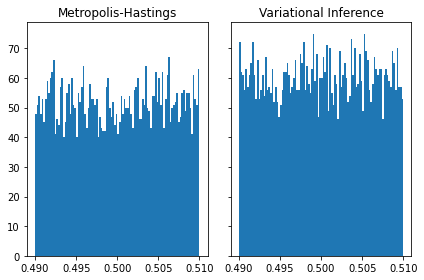

In [30]:
pred_mh_0_5 = y_mh_pred[(y_mh_pred >= .49) & (y_mh_pred <= .51)]
preds_vi_0_5 = y_vi_pred[(y_vi_pred >= .49) & (y_vi_pred <= .51)]

n_bins = 100
# Metropolis Hastings
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(pred_mh_0_5, bins=n_bins)
axs[0].title.set_text('Metropolis-Hastings')

# Variational Inference 
axs[1].hist(preds_vi_0_5, bins=n_bins)
axs[1].title.set_text('Variational Inference')
plt.plot()

[]

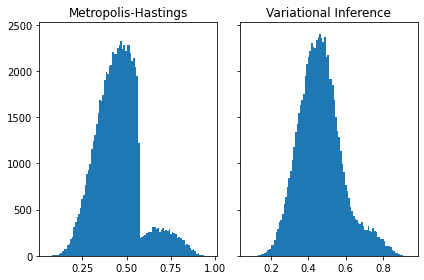

In [31]:
# correct preds
y_mh_discrete = y_mh_pred >= .57 # hardcoded threshold, compute above 
pred_mh_correct = y_mh_pred[y_test == y_mh_discrete] 

y_vi_discrete = y_mh_pred >= .58   # hardcoded threshold, compute above 
pred_vi_correct = y_vi_pred[y_test == y_vi_discrete]

n_bins = 100
# Metropolis Hastings
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(pred_mh_correct, bins=n_bins)
axs[0].title.set_text('Metropolis-Hastings')

# Variational Inference 
axs[1].hist(pred_vi_correct, bins=n_bins)
axs[1].title.set_text('Variational Inference')
plt.plot()

[]

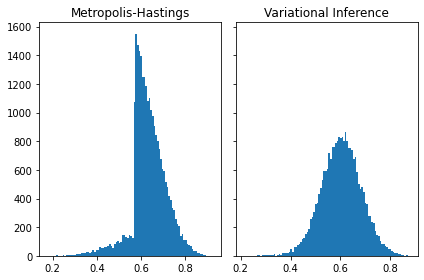

In [32]:
# wrong preds
pred_mh_wrong = y_mh_pred[y_test != y_mh_discrete]
pred_vi_wrong = y_vi_pred[y_test != y_vi_discrete]

n_bins = 100
# Metropolis Hastings
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(pred_mh_wrong, bins=n_bins)
axs[0].title.set_text('Metropolis-Hastings')

# Variational Inference 
axs[1].hist(pred_vi_wrong, bins=n_bins)
axs[1].title.set_text('Variational Inference')
plt.plot()

## 3. Bonus Questions

**Implement the Laplace approximation and compare the predictive mean and variance with the ones obtained by other approximations**

**Super brief thought process**

Calling $H$ the Hessian matrix, we want to implement the following approximation to the posterior

$$ q(w) \backsim N(w| w_{MAP}, S_N) $$

being $w_{MAP}$ the maximum aposteriori solution, i.e. the $w$ which maximes $p(w|y, X)$ evaluated via numerical optimization, e.g. Newton-Raphson method (see slides 15) and $S_N$ the inverse of

$$ S^{-1}_N = - \nabla \nabla log \ p(w | X, y) $$

i.e. the inverse of the matrix of the second derivatives of the log likelihood, which is nothing but

$$ S^{-1}_N = H (log \ p(w | X, y) )$$

Hence

* use a numerical method to compute $w_{MAP}$ (e.g. NR)
* compute the Hessian
* invert the Hessian
* draw N samples from a Gaussian multivariate having $w_{MAP}$ as mean and $H^{-1}$ as variance, being N an hyperparameter, e.g. 100
* use the N samples to make the prediction


I propose two implementations:
* a from scratch version (follows the above steps)
* a `scipy`-based version (described below)

### "Hand made" (from scratch) version


In [33]:
def logposterior_grad(X, y, w, prior_mean, prior_cov):
    """Computes the gradient of the log posterior"""
    p = logistic(X @ w)
    # retrieve the grad
    return X.T @ (y - p) + inverse(prior_cov) @ (w - prior_mean)

    

def logposterior_hessian(X, y, w, prior_cov):
    """Computes the hessian of the logposterior"""
    p = logistic(X @ w)
    hess = (X.T * (p * (1 - p))) @ X + inverse(prior_cov)
    return hess

In [34]:
def newton_raphson_gd(X, y, w, prior_mean, prior_cov, lr=1e-2, tol=1e-5, max_iter=100):
    """Inefficient implementation from wikipedia "dummy-version" pseudocode"""
    # hyper-parameters set by hand
    loss = 1e5
    losses = []
    w_opt = 0
    
    for i in range(max_iter):
             
        # find the next step length.
        grad = logposterior_grad(X, y, w, prior_mean, prior_cov)
        hess = logposterior_hessian(X, y, w, prior_cov)
            
        # update the coefficient for next step 
        w_new = w + lr * inverse(hess) @ grad
        
        # check convergence
        loss_new = logposterior(w, X, y)
        if abs(loss_new - loss) < tol:
            break
        else:
            losses.append(loss_new)
            loss, w = loss_new, w_new
            
        w_opt = w_new
    
    return w_opt, losses

In [35]:
def laplace_approx(X, y, prior_mean, prior_cov, lr = 1e-2, max_iter = 10):
    _, n_feats = X.shape
    w_init = 1e-3 * np.ones(n_feats)
    posterior_mean, _ = newton_raphson_gd(X, y, w_init, prior_mean, prior_cov, lr, max_iter=max_iter)
    
    hess = logposterior_hessian(X, y, posterior_mean, prior_cov)
    posterior_var = inverse(hess)

    return (
       posterior_mean, 
       posterior_var
    )

In [36]:
_, n_feats = X.shape
prior_variance = 1e2 * np.eye(n_feats)
prior_mean = np.zeros(n_feats)

w_map, s_n = laplace_approx(X_train, y_train, prior_mean, prior_variance)

In [37]:
samples = np.random.multivariate_normal(w_map, s_n, 100)

y_laplace = predict(X_test, samples)

100%|██████████| 100/100 [00:01<00:00, 64.23it/s]


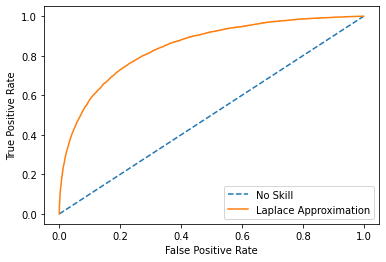


Optimal threshold 0.51
Accuracy score: 0.767380
F1 score: 0.399504
AUC: 0.765555
Sensitivity: 0.767844
Specificity: 0.763267



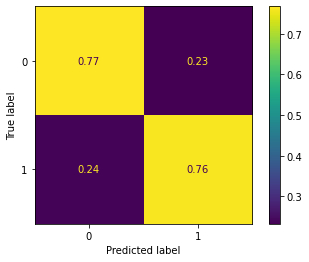

In [38]:
display_roc_cm_scores(y_test, y_laplace, "Laplace Approximation")

### Scipy version

This version employes `scipy.optimize.minimize` to compute $w_{MAP}$ and $S_N$ and now it reduces to the previous approach.

In [39]:
import scipy

w_init = np.zeros(n_feats)

def neg_logposterior(w, X, y):
    y_hat = logistic(X @ w)
    log_ll = bernoulli_density(y,y_hat)
    prior = gaussian_density(w)

    return - (np.sum(log_ll) + np.sum(prior))

def laplace_approx_scipy(X, y, w_init):
  # solve using scipy
  solution = scipy.optimize.minimize(
      neg_logposterior, 
      w_init, 
      args=(X, y), 
      method='BFGS', 
      options={'disp':True, 'maxiter':10}
  )
  # retrieve w_map and H^-1
  return solution.x, solution.hess_inv
  


In [40]:
w_map_scipy, hess_scipy = laplace_approx_scipy(X_train, y_train, w_init)

         Current function value: 66768.740503
         Iterations: 10
         Function evaluations: 4848
         Gradient evaluations: 24


100%|██████████| 5000/5000 [01:21<00:00, 60.99it/s]


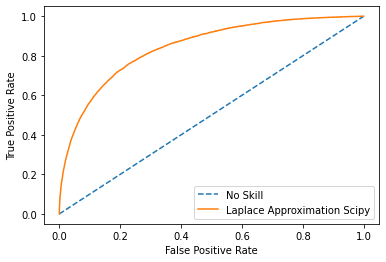


Optimal threshold 0.51
Accuracy score: 0.769850
F1 score: 0.401041
AUC: 0.765486
Sensitivity: 0.770960
Specificity: 0.760012



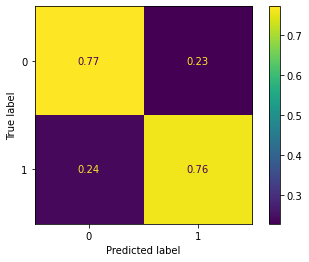

In [41]:
# now we do as above:
# - draw samples 
# - predict
# - display metrics

samples = np.random.multivariate_normal(w_map_scipy, hess_scipy,  5000)

y_laplace_scipy = predict(X_test, samples)

display_roc_cm_scores(y_test, y_laplace_scipy, "Laplace Approximation Scipy")

#### **Suggest and implement ways to improve the performance**

As mentioned above, being the dataset highly imbalanced with respect to one class, we might considering rebalancing the dataset using an oversampling technique, like SMOTE or undersampling, i.e. pick a handful of the sample belonging to the majority class to rebalance the distributions (at the cost of getting rid of a big part of the dataset).